In [42]:
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn

seaborn.set_context("talk")

In [54]:
def parse_log(fname):
    with open(fname) as f:
        lines = f.readlines()

    messages = []
    for line in lines:
        try:
            messages.append(json.loads(line.strip()))
        except json.JSONDecodeError:
            pass
    return messages


def plot_wait_time(messages, ax, title="Time waiting"):
    if title:
        ax.set_title(title)

    wait_times = []
    end = None
    for m in messages:
        if m["event"] == "training end":
            end = m["time"]
        if m["event"] == "training start" and end is not None:
            wait_times.append(m["time"] - end)

    wait_times = np.array(wait_times)
    max_show = wait_times.mean() + 3 * wait_times.std()

    print("average wait time", wait_times.mean())

    ax.hist(wait_times, bins=np.linspace(0, max_show, 100), color="#6D0EDB")[-1]
    ax.set_xlabel("time (sec)")


def plot_log(messages, ax, title=""):
    origin = messages[0]["time"]
    assert messages[0]["event"] == "run start"

    rows = {"setup": 3, "get-batch": 2, "train": 1, "epoch": 0}

    ax.set_yticks(list(rows.values()), labels=list(rows))

    if title:
        ax.set_title(title)

    data = {"batches": []}

    for m in messages:
        t = m["time"] - origin

        if m["event"] == "setup end":
            ax.barh(
                rows["setup"],
                m["duration"],
                left=t - m["duration"],
                edgecolor="k",
                linewidth=0.1,
                color="#6D0EDB",
                zorder=1,
            )

        if m["event"] == "get-batch end":
            ax.barh(
                rows["get-batch"],
                m["duration"],
                left=t - m["duration"],
                # alpha=0.5,
                color="#C396F9",
                zorder=1,
            )
            data["batches"].append(m["duration"])

        if m["event"] == "training end":
            ax.barh(
                rows["train"],
                m["duration"],
                left=t - m["duration"],
                color="#FF6554",
                zorder=1,  # edgecolor="k", linewidth=0.1,
            )

        if m["event"] == "epoch end":
            ax.barh(
                rows["epoch"],
                m["duration"],
                left=t - m["duration"],
                edgecolor="k",
                linewidth=0.1,
                color="#FF9E0D",
                zorder=1,
            )

    ax.grid(axis="x", zorder=0, alpha=0.5)
    ax.set_xlabel("time (sec)")

    print("average batch duration", np.mean(data["batches"]))


def plot(fname):
    messages = parse_log(fname)
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6), width_ratios=[3, 1], dpi=400)

    plot_log(messages, axes[0], title="")
    plot_wait_time(messages, axes[1], title="")

    for m in messages:
        if m["event"] == "run start":
            text_str = "\n".join([f"{k}: {v}" for k, v in m["locals"].items() if v is not None])
            props = dict(boxstyle="round", facecolor="#F5F5F5", alpha=0.5)
            fig.text(
                0.5,
                -0.03,
                text_str,
                fontsize=14,
                horizontalalignment="center",
                verticalalignment="top",
                bbox=props,
            )
            break

average batch duration 0.3691523852624709
average wait time 1.4760194284427635


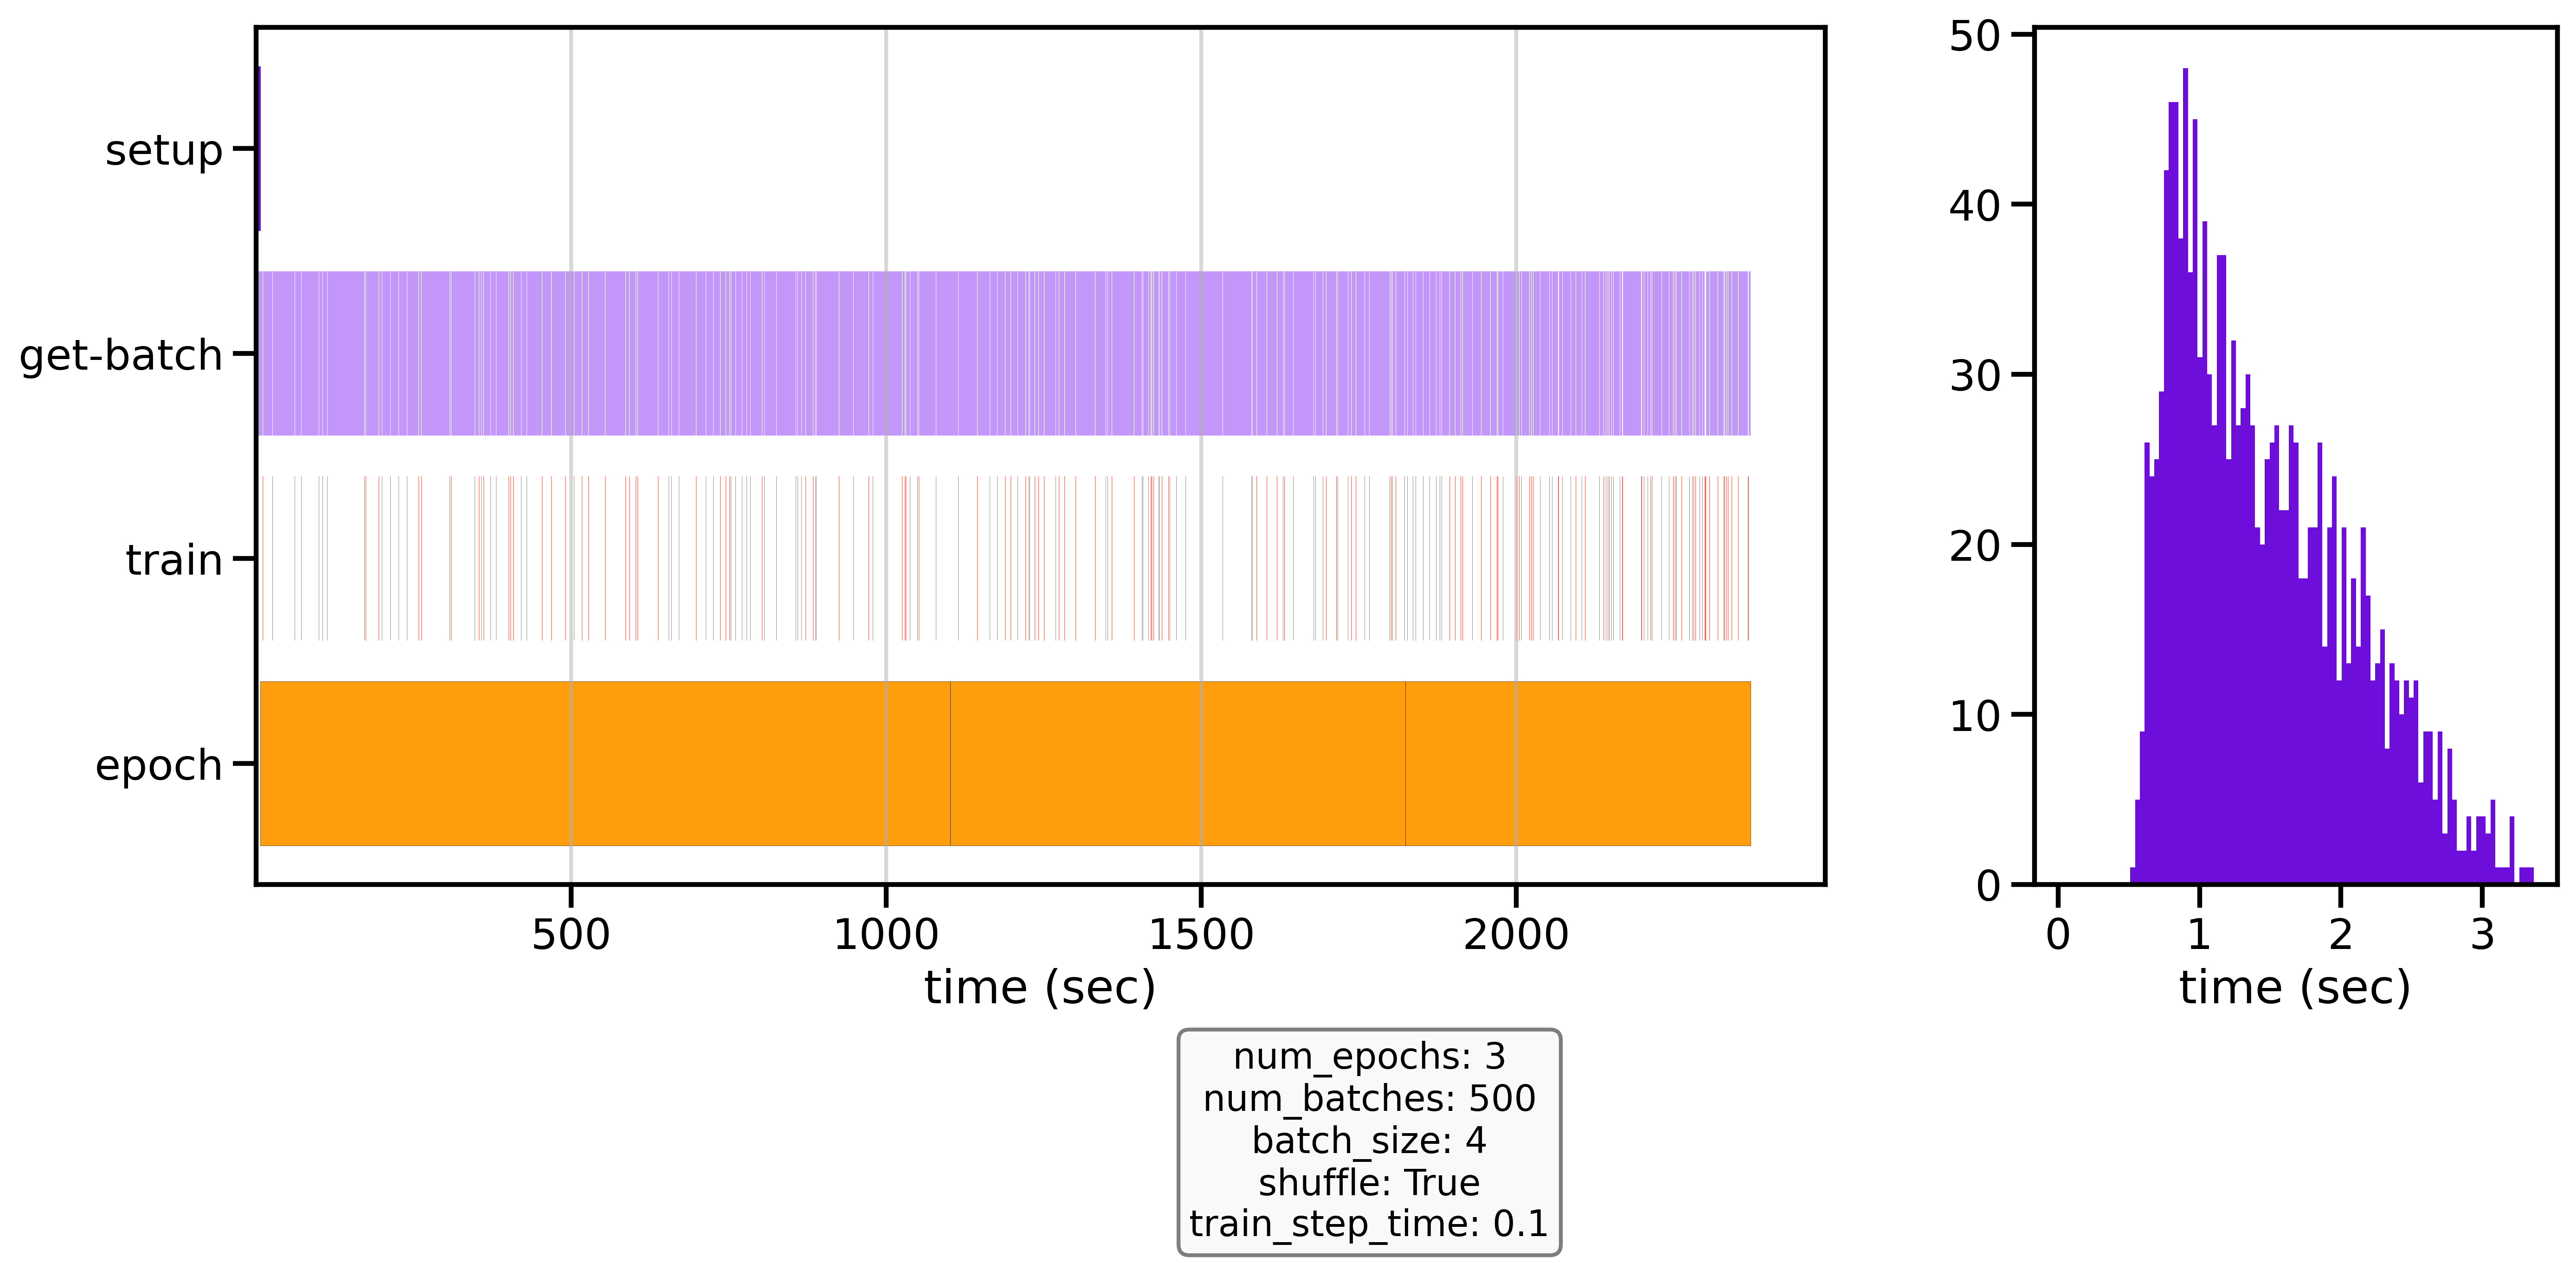

In [55]:
plot("logs/simple-4-3-500.txt")

average batch duration 0.31024867596386146
average wait time 0.005857009713242694


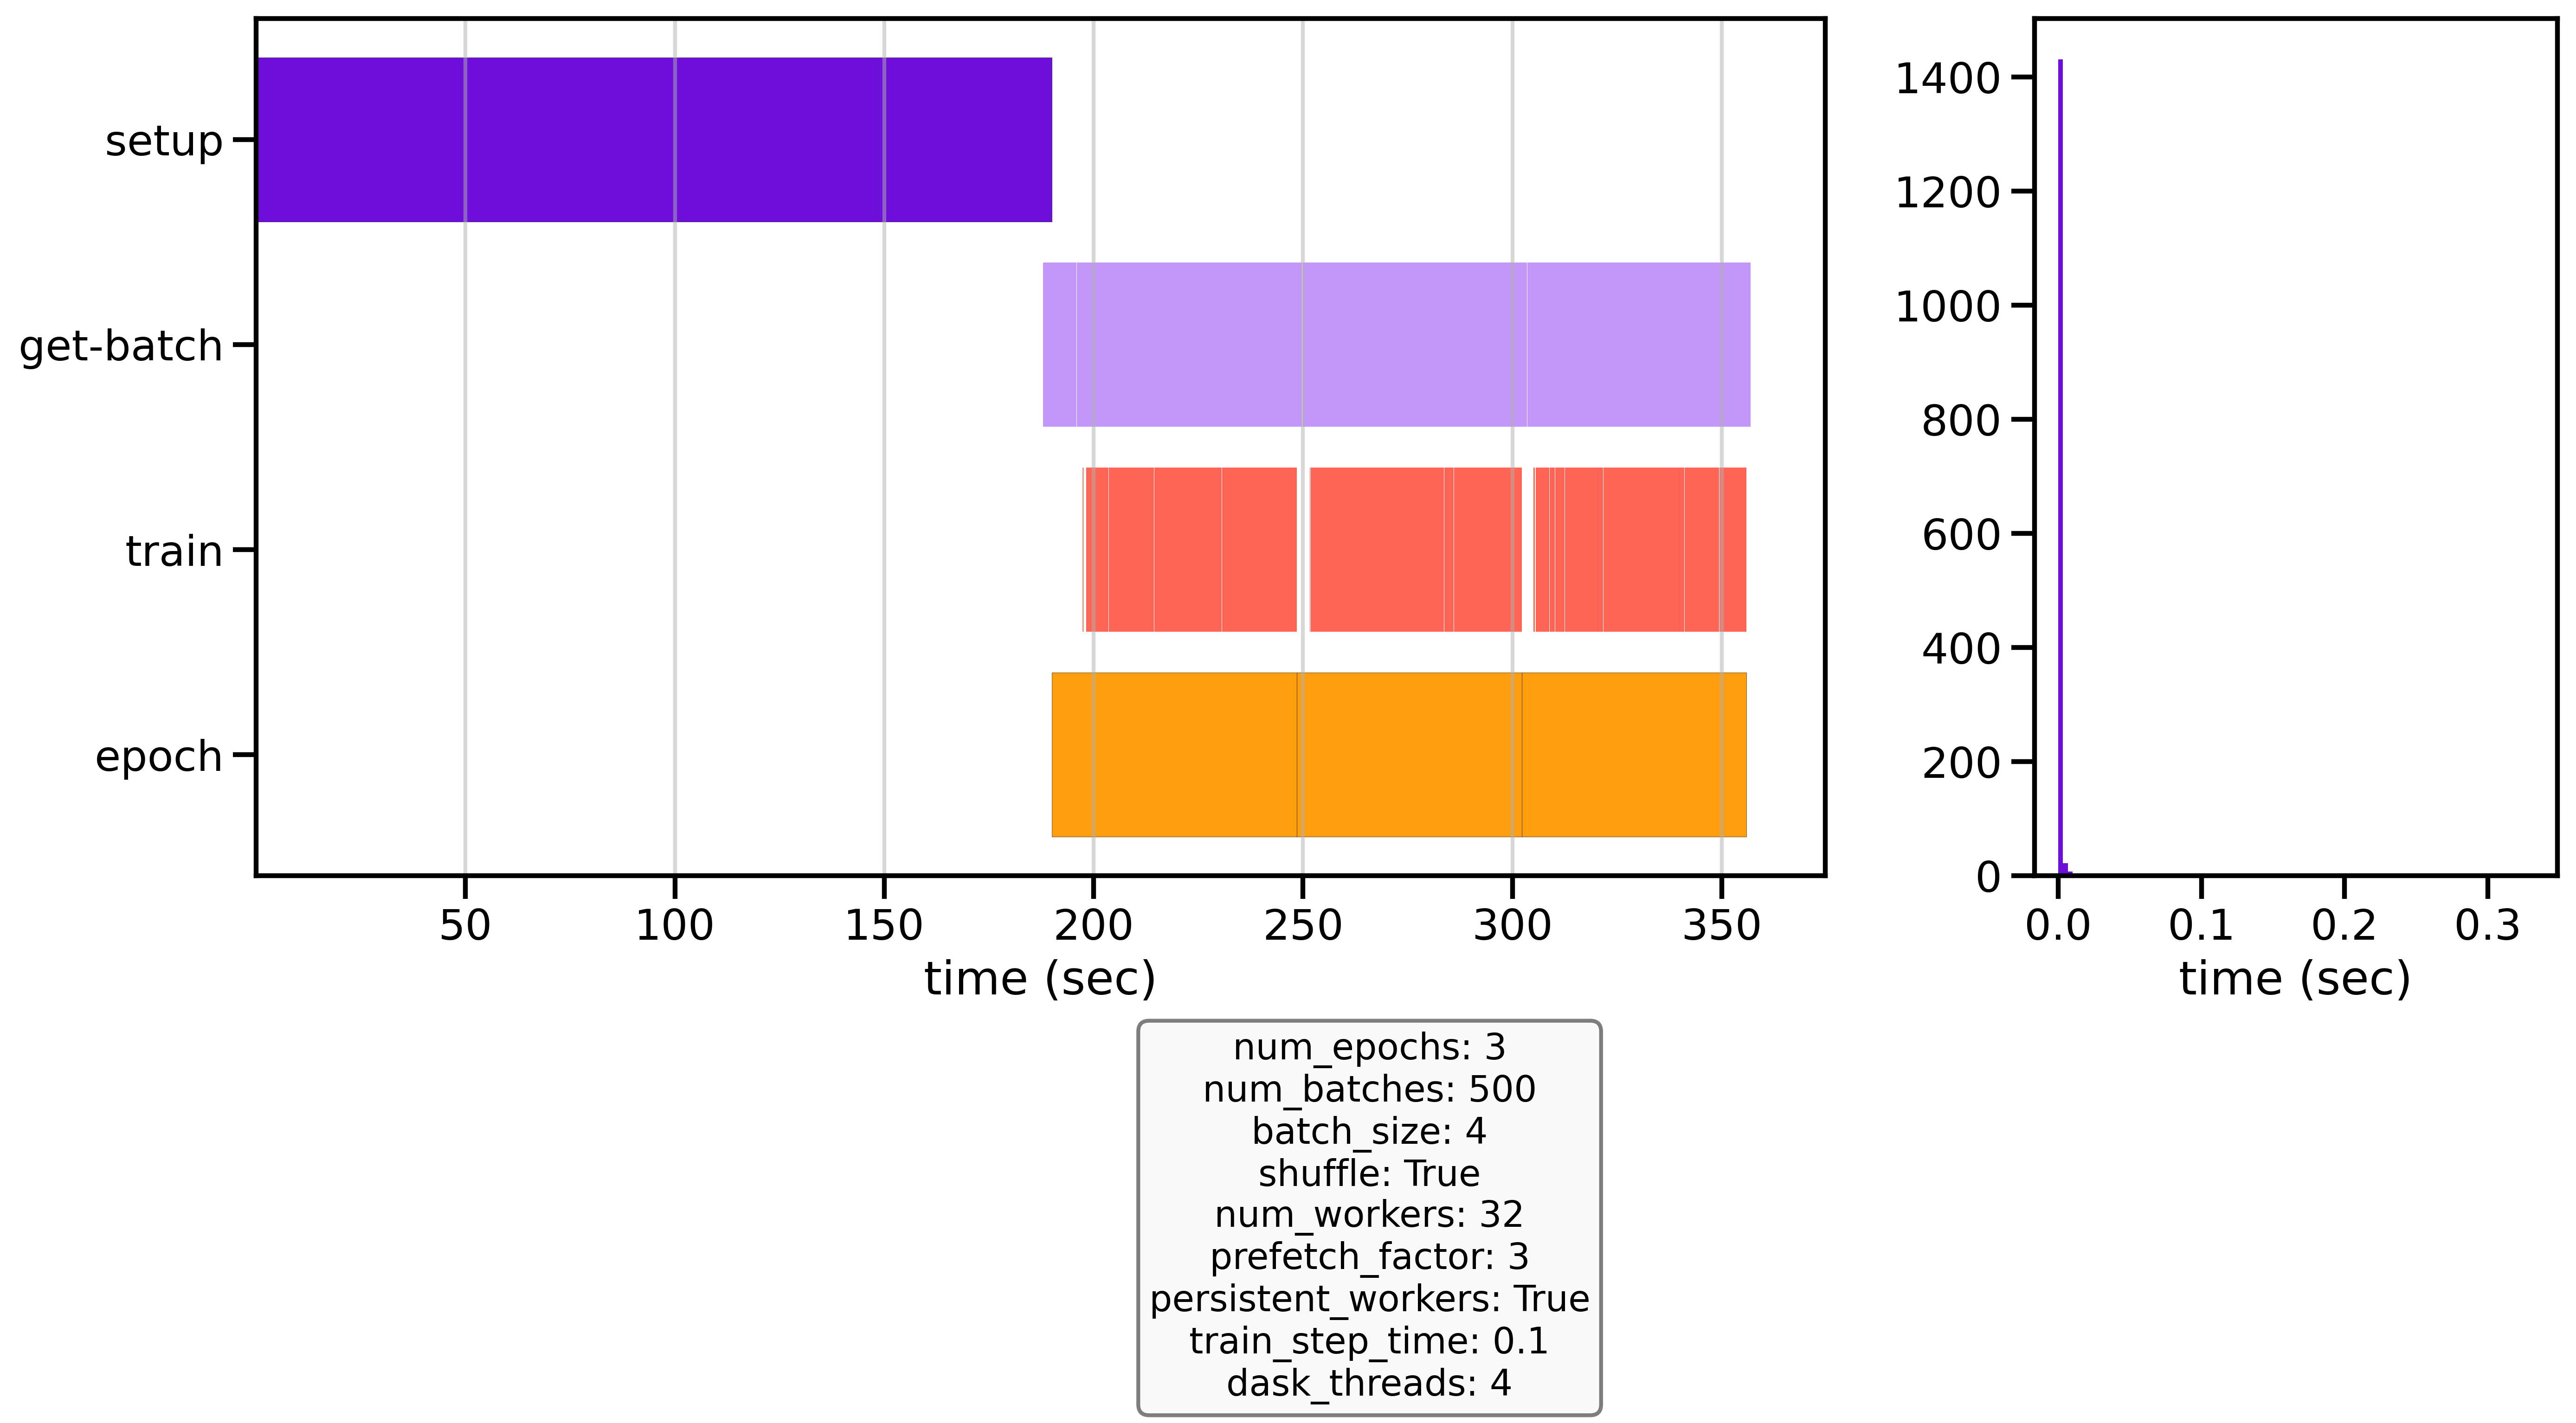

In [56]:
plot("logs/best-case-4-3-500-4-3.txt")

average batch duration 0.3691523852624709


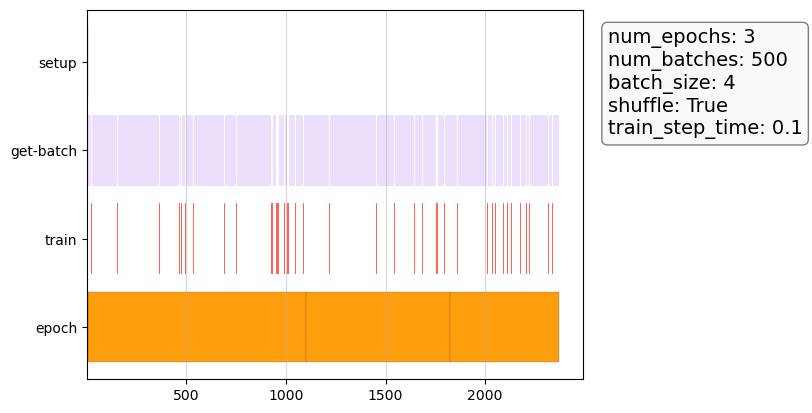

In [10]:
# !python main.py --batch-size 4 --num-epochs 3 --num-batches 500 --shuffle > logs/simple-4-3-500.txt
plot_log("logs/simple-4-3-500.txt")

average batch duration 0.31024867596386146


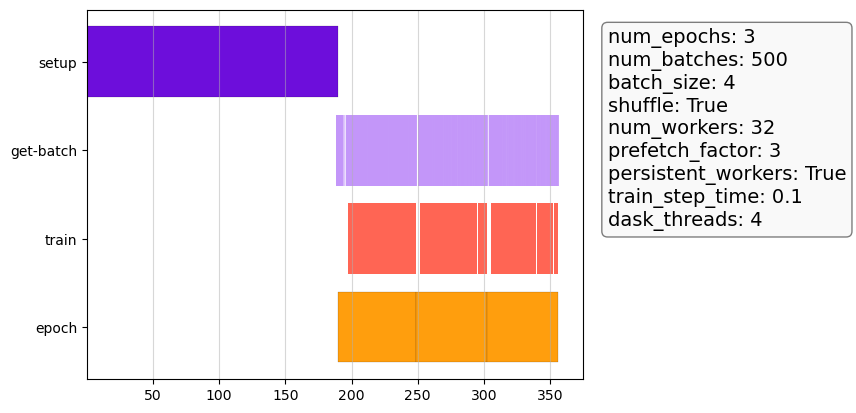

In [9]:
# !python main.py --batch-size 4 --num-epochs 3 --num-batches 500 --num-workers 32 --persistent-workers --dask-threads 4 --shuffle --prefetch-factor 3 > logs/best-case-4-3-500-4-3.txt
plot_log("logs/best-case-4-3-500-4-3.txt")